In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from dolfin import *
import math
import numpy as np
import logging

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)

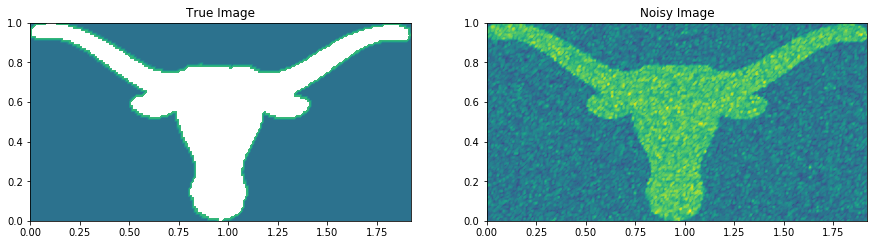

In [2]:
# Set the level of noise:
noise_std_dev = .3

# Load the image from file
data = np.loadtxt('hw3/image.dat', delimiter=',')
np.random.seed(seed=1)

noise = noise_std_dev * np.random.randn(data.shape[0], data.shape[1])
Lx = float(data.shape[1]) / float(data.shape[0])
Ly = 1.

mesh = RectangleMesh(Point(0, 0), Point(Lx, Ly), 200, 100)
V = FunctionSpace(mesh, "Lagrange", 1)


# Generate the true image (u_true) and the noisy data (u_0)
class Image(UserExpression):
    def __init__(self, Lx, Ly, data, **kwargs):
        super().__init__(kwargs)
        self.data = data
        self.hx = Lx / float(data.shape[1] - 1)
        self.hy = Ly / float(data.shape[0] - 1)

    def eval(self, values, x):
        j = int(math.floor(x[0] / self.hx))
        i = int(math.floor(x[1] / self.hy))
        values[0] = self.data[i, j]

    def value_shape(self):
        return ()


trueImage = Image(Lx, Ly, data, element=V.ufl_element())
noisyImage = Image(Lx, Ly, data + noise, element=V.ufl_element())

u_true = interpolate(trueImage, V)
u_0 = interpolate(noisyImage, V)

vmin = np.min(u_0.vector().get_local())
vmax = np.max(u_0.vector().get_local())

plt.figure(figsize=[15, 15])
plt.subplot(1, 2, 1)
plot(u_true, title="True Image", vmin=vmin, vmax=vmax)
plt.subplot(1, 2, 2)
plot(u_0, title="Noisy Image", vmin=vmin, vmax=vmax)
plt.show()

In [6]:
# Tikhonov regularization
def tikhonov_solver(alpha):
    V_cg = FunctionSpace(mesh, 'CG', 1)
    v_test = TestFunction(V_cg)
    u_trial = TrialFunction(V_cg)
    d = interpolate(noisyImage, V_cg)

    stiffness_form = alpha * inner(grad(u_trial), grad(v_test)) * dx + u_trial * v_test * dx
    rhs_form = d * v_test * dx

    u = Function(V_cg)
    solve(stiffness_form == rhs_form, u)
    return u, V_cg


alphas = 10 ** np.arange(-6, 2.5, 0.5)
smoothed_by_tikhonov = dict()
for alpha in alphas:
    smoothed_by_tikhonov[alpha] = tikhonov_solver(alpha)

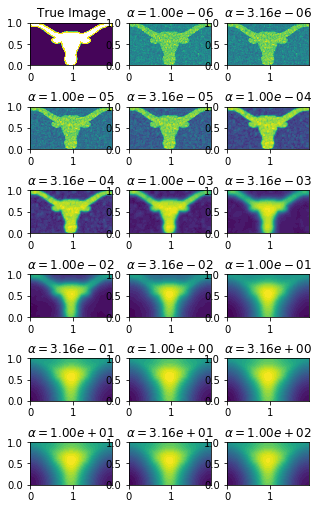

In [7]:
# Use naked eye to select the best alpha
fig, axs = plt.subplots(ncols=3, nrows=(len(alphas) + 2) // 3, figsize=(5, 9))
pyplot.sca(axs.flatten()[0])
plot(u_true, title="True Image", wireframe=False)
for i, alpha in enumerate(alphas):
    pyplot.sca(axs.flatten()[i + 1])
    plot(smoothed_by_tikhonov[alpha][0], title=f'$\\alpha={alpha:.2e}$', wireframe=False)
plt.savefig('hw3/p4-tikhonov-comparison.png')

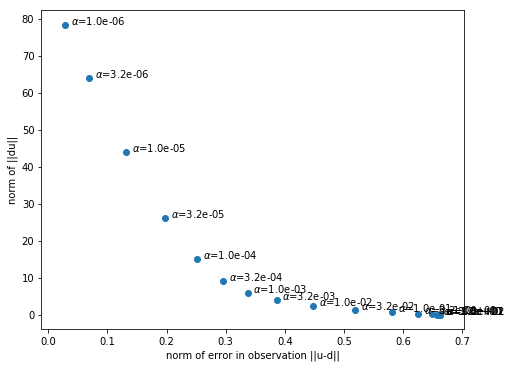

In [9]:
# Use L-shape curve to select the best alpha
u_norms = []
e_norms = []
for alpha in alphas:
    u, V_cg = smoothed_by_tikhonov[alpha]
    d = interpolate(noisyImage, V_cg)
    u_norms.append(np.sqrt(assemble(inner(grad(u), grad(u)) * dx)))
    e_norms.append(np.sqrt(assemble((u-d) ** 2 * dx)))

fig = plt.figure(constrained_layout=True, figsize=(7, 5))
m_norm_label = 'norm of model param ||m||'
e_norm_label = 'norm of error in observation ||Fm-d||'
plt.scatter(x=e_norms, y=u_norms)
plt.gca().set(xlabel='norm of error in observation ||u-d||', ylabel='norm of ||du||')
for alpha, e_norm, u_norm in zip(alphas, e_norms, u_norms):
    plt.text(e_norm + 0.01, u_norm + 0.1, f'$\\alpha$={alpha:.1e}')
plt.savefig('hw3/p4-tikhonov-L-curve.eps')

In [5]:
from unconstrainedMinimization import InexactNewtonCG

# TV regularization
def TV_solver(alpha, delta, max_iter=50):
    Vh = FunctionSpace(mesh, "Lagrange", 2)
    d = interpolate(noisyImage, Vh)

    u = Function(Vh)
    u_hat = TestFunction(Vh)
    u_tilde = TrialFunction(Vh)

    # Define the energy functional
    beta = Constant(100)

    E = (Constant(.5) * (u - d) * (u - d) * dx +
         alpha * sqrt(inner(nabla_grad(u), nabla_grad(u)) + delta) * dx)

    grad = (u_hat * (u - d) * dx +
            alpha * inner(nabla_grad(u_hat), nabla_grad(u)) / sqrt(inner(nabla_grad(u), nabla_grad(u)) + delta) * dx)

    H = (u_hat * u_tilde * dx +
         alpha * inner(nabla_grad(u_hat), nabla_grad(u_tilde)) / sqrt(inner(nabla_grad(u), nabla_grad(u)) + delta) * dx -
         alpha * inner(nabla_grad(u), nabla_grad(u_tilde)) * inner(nabla_grad(u_hat), nabla_grad(u)) / pow(inner(nabla_grad(u), nabla_grad(u)) + delta, 1.5) * dx)

    solver = InexactNewtonCG()
    solver.parameters["rel_tolerance"] = 1e-5
    solver.parameters["abs_tolerance"] = 1e-9
    solver.parameters["gdu_tolerance"] = 1e-18
    solver.parameters["max_iter"] = max_iter
    solver.parameters["c_armijo"] = 1e-5
    solver.parameters["print_level"] = 1
    solver.parameters["max_backtracking_iter"] = 10
    solver.parameters["cg_coarse_tolerance"] = .2

    solver.solve(E, u, grad, H)

    return u, solver.it, solver.total_cg_iter

In [9]:
def test_wrapper(alpha, delta, max_iter):
    u, _, _ = TV_solver(alpha, delta, max_iter)
    plt.figure()
    plot(u)
    plt.title(f'$\\alpha={alpha:.1e}, \\delta={delta:.1e}$')
    plt.savefig(f'hw3/alpha={alpha:.1e}-delta={delta:.1e}.png')

 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    8.422473e-01    1.823360e-02   -1.244129e-01    1.000000e+00    2.000000e-01       1
  1    8.413683e-01    1.839164e-03   -1.753529e-03    1.000000e+00    2.000000e-01       4
  2    8.413675e-01    6.310797e-05   -1.712716e-06    1.000000e+00    2.000000e-01       4
  3    8.413675e-01    4.219963e-06   -4.539624e-09    1.000000e+00    1.227296e-01       4
  4    8.413675e-01    1.074957e-07   -1.851026e-11    1.000000e+00    3.173668e-02       5
  5    8.413675e-01    1.347039e-10   -5.036979e-15    1.000000e+00    5.065271e-03       8
Norm of the gradient less than tolerance
Inexact Newton CG converged in  5 nonlinear iterations and  26 linear iterations.
Final norm of the gradient 1.34703909057401e-10
Value of the cost functional 0.8413674857928013


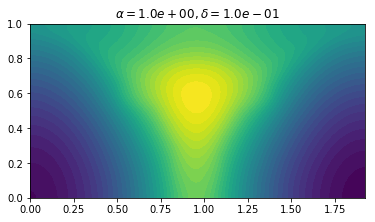

In [10]:
test_wrapper(alpha=1e-0, delta=1e-1, max_iter=100)

 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    2.895257e-01    1.657951e-02   -1.363106e-01    1.000000e+00    2.000000e-01       1
  1    2.814174e-01    2.515605e-03   -1.439385e-02    1.000000e+00    2.000000e-01       3
  2    2.806304e-01    1.632243e-03   -1.379794e-03    1.000000e+00    2.000000e-01       3
  3    2.805513e-01    2.810394e-04   -1.437616e-04    1.000000e+00    2.000000e-01       4
  4    2.805476e-01    5.926502e-05   -7.018193e-06    1.000000e+00    2.000000e-01       4
  5    2.805475e-01    7.772361e-06   -1.183845e-07    1.000000e+00    1.189341e-01       4
  6    2.805475e-01    3.149948e-07   -1.142855e-09    1.000000e+00    4.307087e-02       6
  7    2.805475e-01    2.145612e-09   -1.229320e-12    1.000000e+00    8.670795e-03       8
Norm of the gradient less than tolerance
Inexact Newton CG converged in  7 nonlinear iterations and  33 linear iterations.
Final norm of the gradient 2.145612113146062e-09


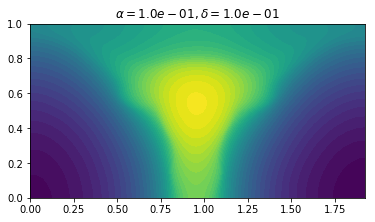

In [11]:
test_wrapper(alpha=1e-1, delta=1e-1, max_iter=100)

In [ ]:
test_wrapper(alpha=1e-2, delta=1e-1, max_iter=100)

 17    1.103010e-01    6.957045e-03   -9.028474e-02    3.125000e-02    2.000000e-01       2
 18    1.102644e-01    6.774513e-03   -8.992826e-02    3.125000e-02    2.000000e-01       2
 19    1.099687e-01    6.608901e-03   -8.460098e-02    3.125000e-02    2.000000e-01       2
 20    1.088797e-01    6.467758e-03   -8.559117e-02    1.562500e-02    2.000000e-01       2
 21    1.088746e-01    6.098506e-03   -9.323427e-03    6.250000e-02    2.000000e-01       2
 22    1.088061e-01    5.800350e-03   -2.172176e-02    3.125000e-02    2.000000e-01       1
 23    1.087959e-01    5.578439e-03   -2.297520e-02    3.125000e-02    2.000000e-01       1
 24    1.087162e-01    5.381360e-03   -2.361805e-02    3.125000e-02    2.000000e-01       1
 25    1.084080e-01    5.269270e-03   -2.600914e-02    1.562500e-02    2.000000e-01       1
 26    1.083680e-01    5.183157e-03   -7.872561e-03    1.562500e-02    2.000000e-01       2
 27    1.083537e-01    5.105944e-03   -9.270297e-03    1.562500e-02    2.000000e

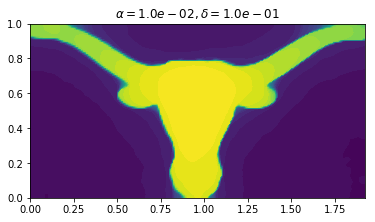

 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    1.105053e-01    2.171465e-03   -3.488205e-01    1.000000e+00    2.000000e-01       1
  1    6.669649e-02    1.534633e-03   -9.504335e-02    1.000000e+00    2.000000e-01       1
  2    6.466535e-02    1.731944e-03   -3.116330e-02    2.500000e-01    2.000000e-01       1
  3    6.314375e-02    1.360470e-03   -4.607367e-02    1.250000e-01    2.000000e-01       1
  4    6.265671e-02    1.351689e-03   -2.650293e-02    1.250000e-01    2.000000e-01       1
  5    6.160097e-02    1.136646e-03   -3.498477e-02    6.250000e-02    2.000000e-01       1
  6    6.132685e-02    1.083463e-03   -1.265332e-02    6.250000e-02    2.000000e-01       1
  7    6.120269e-02    9.790609e-04   -1.079630e-02    6.250000e-02    2.000000e-01       1
  8    6.109867e-02    9.425574e-04   -9.090283e-03    6.250000e-02    2.000000e-01       1
  9    6.105454e-02    8.734867e-04   -1.085600e-02    6.250000e-02    2.000000e

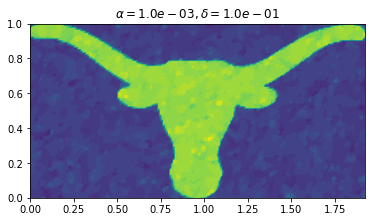

In [13]:
test_wrapper(alpha=1e-3, delta=1e-1, max_iter=100)

 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    2.334630e-01    1.101564e-02   -1.619396e-01    1.000000e+00    2.000000e-01       1
  1    2.031315e-01    3.912201e-03   -4.699348e-02    1.000000e+00    2.000000e-01       3
  2    1.853799e-01    1.220039e-02   -3.506171e-02    1.000000e+00    2.000000e-01       3
  3    1.845114e-01    1.396370e-02   -2.349940e-02    5.000000e-01    2.000000e-01       3
  4    1.830287e-01    1.303346e-02   -1.416174e-01    6.250000e-02    2.000000e-01       4
  5    1.813567e-01    1.241047e-02   -1.022624e-01    3.125000e-02    2.000000e-01       4
  6    1.809397e-01    1.186776e-02   -4.074828e-02    3.125000e-02    2.000000e-01       4
  7    1.806214e-01    1.174089e-02   -4.613407e-02    1.562500e-02    2.000000e-01       5
  8    1.804817e-01    1.132842e-02   -2.218051e-02    3.125000e-02    2.000000e-01       4
  9    1.803137e-01    1.117599e-02   -3.716790e-02    1.562500e-02    2.000000e

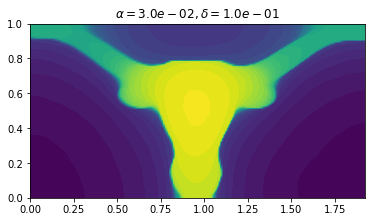

In [14]:
test_wrapper(alpha=3e-2, delta=1e-1, max_iter=100)

 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    2.360800e-01    1.069204e-02   -1.827055e-01    1.000000e+00    2.000000e-01       1
  1    2.051229e-01    3.509445e-03   -5.023198e-02    1.000000e+00    2.000000e-01       3
  2    1.922480e-01    8.518255e-03   -2.460251e-02    1.000000e+00    2.000000e-01       3
  3    1.903098e-01    8.854646e-03   -1.050040e-02    5.000000e-01    2.000000e-01       3
  4    1.896172e-01    7.900541e-03   -3.242983e-02    6.250000e-02    2.000000e-01       2
  5    1.892170e-01    7.386917e-03   -1.342117e-02    6.250000e-02    2.000000e-01       2
  6    1.890663e-01    6.944073e-03   -6.869360e-03    6.250000e-02    2.000000e-01       3
  7    1.889355e-01    6.693586e-03   -9.414253e-03    3.125000e-02    2.000000e-01       2
  8    1.888511e-01    5.827923e-03   -4.867765e-03    1.250000e-01    2.000000e-01       3
  9    1.887235e-01    5.716124e-03   -3.198745e-02    1.562500e-02    2.000000e

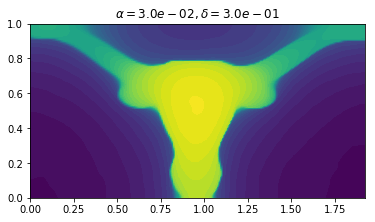

In [15]:
test_wrapper(alpha=3e-2, delta=3e-1, max_iter=100)

 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    2.470600e-01    1.003460e-02   -2.122417e-01    1.000000e+00    2.000000e-01       1
  1    2.195981e-01    3.964176e-03   -4.746089e-02    1.000000e+00    2.000000e-01       2
  2    2.108167e-01    4.007982e-03   -1.603889e-02    1.000000e+00    2.000000e-01       3
  3    2.094126e-01    3.950549e-03   -4.720742e-03    5.000000e-01    2.000000e-01       3
  4    2.093815e-01    3.348845e-03   -5.990854e-03    1.250000e-01    2.000000e-01       2
  5    2.092063e-01    3.141219e-03   -9.508143e-03    6.250000e-02    2.000000e-01       2
  6    2.090651e-01    2.973860e-03   -9.182457e-03    3.125000e-02    2.000000e-01       1
  7    2.090099e-01    2.422153e-03   -2.246548e-03    2.500000e-01    2.000000e-01       3
  8    2.088715e-01    2.229275e-03   -1.168243e-02    3.125000e-02    2.000000e-01       1
  9    2.087902e-01    2.171680e-03   -9.821052e-03    1.562500e-02    2.000000e

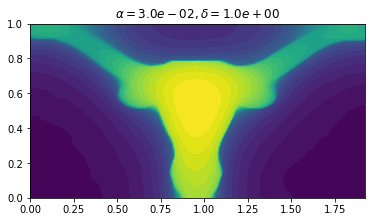

In [16]:
test_wrapper(alpha=3e-2, delta=1e-0, max_iter=100)

In [17]:
deltas = 10 ** np.arange(-4, 1.1, 0.5)
results = dict()
for delta in deltas:
    results[delta] = TV_solver(alpha=3e-2, delta=delta, max_iter=300)

 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    2.352758e-01    1.130436e-02   -1.244884e-01    1.000000e+00    2.000000e-01       1
  1    2.312051e-01    5.468095e-03   -4.802320e-03    1.000000e+00    2.000000e-01       4
  2    1.948879e-01    1.767680e-02   -5.942731e-02    1.000000e+00    2.000000e-01       4
  3    1.935687e-01    2.191080e-02   -1.108305e-01    6.250000e-02    2.000000e-01       7
  4    1.914624e-01    2.169380e-02   -5.141698e-01    7.812500e-03    2.000000e-01       7
  5    1.913551e-01    2.124735e-02   -2.067754e-01    1.562500e-02    2.000000e-01       7
  6    1.901026e-01    2.097745e-02   -3.378786e-01    7.812500e-03    2.000000e-01       5
  7    1.897667e-01    2.079204e-02   -2.119189e-01    7.812500e-03    2.000000e-01       5
  8    1.896583e-01    2.053760e-02   -2.387197e-01    7.812500e-03    2.000000e-01       5
  9    1.892660e-01    2.034794e-02   -2.544158e-01    7.812500e-03    2.000000e

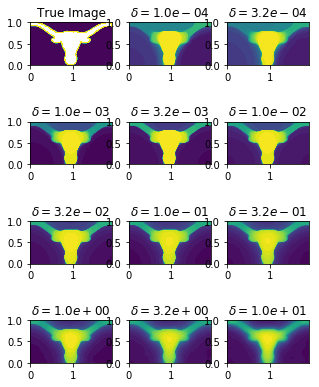

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=(len(deltas) + 2) // 3, figsize=(5, 7))
pyplot.sca(axs.flatten()[0])
plot(u_true, title="True Image", wireframe=False)
for i, delta in enumerate(deltas):
    pyplot.sca(axs.flatten()[i + 1])
    plot(results[delta][0], title=f'$\\delta={delta:.1e}$', wireframe=False)
plt.savefig('hw3/p4-tv-comparison.png')

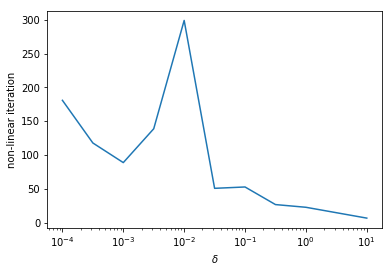

In [25]:
# Non-linear iterations needed
plt.figure()
plt.plot(deltas, np.array([results[delta][1] for delta in deltas]))
plt.gca().set(xscale='log')
plt.xlabel('$\\delta$')
plt.ylabel('non-linear iteration')
plt.savefig('hw3/p4-tv-iterations.png')